# Hands-on tutorial

This tutorial is a slightly modified version of the tutorial ["An Intersectional Approach to Model Construction and Evaluation in Mental Health Care (Online)"](https://facctconference.org/2022/acceptedtuts#construct) by Marta Maslej (CAMH), Laura Sikstrom (CAMH), Darla Reslan (Toronto) and Yifan Wang (McMaster) given at ACT FAccT 2022.

The tutorial makes use of simulated data. Some of the categories in the original dataset have been remaped to more abstract categories. The modified dataset is entirely fictitious and the dataset should only be viewed as an illustrative artefact for the purposes of this tutorial.

This tutorial makes use of fairlearn-package (learn more on fairlearn.org) and a full version of the original tutorial can be found [here](https://fairlearn.org/v0.11/auto_examples/plot_intersectional_bias.html#sphx-glr-auto-examples-plot-intersectional-bias-py).

# Hypothetical scenario

You work in a national public health agency. Another team in the agency has created a model to predict the diagnosis of affective disorder (0) or schizophrenia (1). The team claims a performance above known human accuracy levels, and the agency is excited to deploy the model in a country wide trial.

Before the model can be trialled, they contact your team to help assess the fairness of this model. You are given

* the model
* the training set
* the test set

Your task is to inspect model fairness with respect to region and gender, and to report any problems back to the production team.

### Setup 

Please run this at the start!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns

#import os
#path = os.getcwd()
import utils

#%load_ext autoreload
#%autoreload 2

ModuleNotFoundError: No module named 'pandas'

In [53]:
#read in train and test sets
train = utils.fetch_data("train.csv", remap_cols=('Race','Region'), remap_vals=utils.remap_race)
test  = utils.fetch_data("test.csv", remap_cols=('Race','Region'), remap_vals=utils.remap_race)

### Exploring the data

In [23]:
train.head()

,Diagnosis,Sex,Housing,Delay,Anhedonia,Dep_Mood,Sleep,Tired,Appetite,Rumination,Concentration,Psychomotor,Delusion,Suspicious,Withdrawal,Passive,Tension,Unusual_Thought,Region
0,1,Male,Stable,No,5.776834,7.945197,6.538275,5.821416,5.589637,5.990781,5.843773,3.682413,3.544660,1.396333,4.292102,5.820395,6.763654,1.165049,Vest
1,0,Male,Stable,No,7.298161,8.605159,5.386226,6.657438,6.115384,4.740278,6.033697,5.381531,2.077573,2.520095,2.950640,4.904143,3.009537,1.635291,Nord
2,1,Female,Unstable,No,5.478631,6.581001,7.314665,5.759076,4.096647,4.004291,7.184592,5.588698,3.076944,1.552275,5.364331,5.332242,6.689860,3.030685,Midt-Norge
3,0,Female,Stable,Yes,7.440324,6.482757,7.519543,5.483178,5.532212,7.980671,6.172174,6.222733,3.657648,2.413774,3.739074,3.874793,6.749632,1.548987,Midt-Norge
4,1,Male,Stable,Yes,7.655051,6.159573,7.658879,5.310127,5.067152,3.445936,8.724369,4.631259,3.452163,4.862946,3.967482,3.537156,6.034795,3.502844,Sør-Øst


/var/folders/wv/w4ty1sss1yv_39zvj5qp49bm0000gn/T/ipykernel_1574/2568873236.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


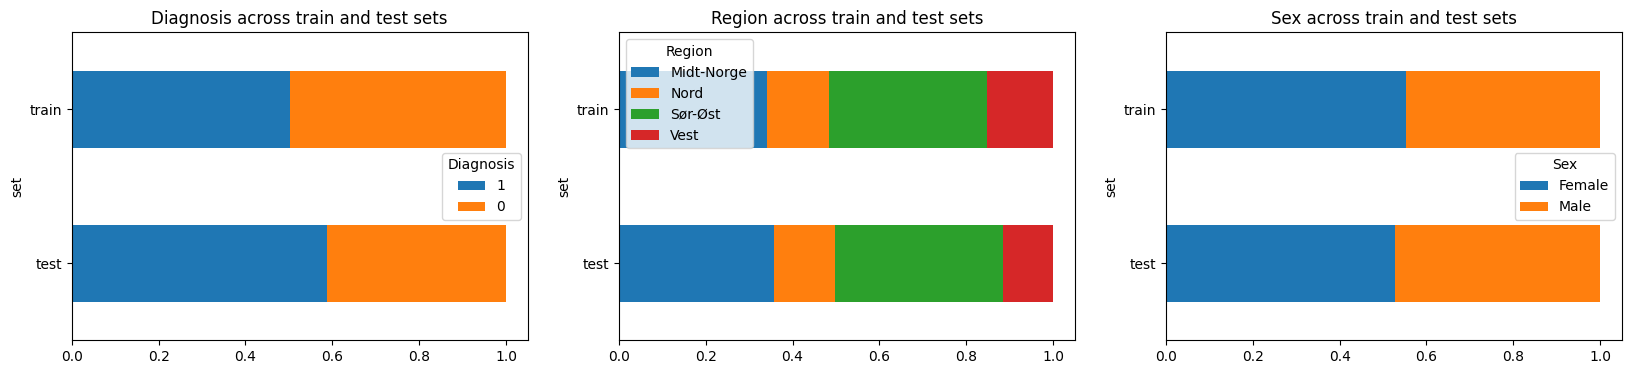

In [24]:
# Add a category for train vs test, and create a merged dataframe containing both train and test
train["set"] = "train"
test["set"] = "test"
all = pd.merge(train, test, on = list(train.columns), how='outer')

# Format graphs
variables_to_inspect = ["Diagnosis","Region", "Sex"]
dist = {}
for var in variables_to_inspect:
    dist[var] = utils.group_pivot("set", var, all)




#diagnosis = utils.group_pivot("set", "Diagnosis", all)
#sex = utils.group_pivot("set", "Region", all)
#region = utils.group_pivot("set", "Sex", all)

#fig, axs = plt.subplots(1, 3, figsize=(20,4))
fig, axs = plt.subplots(1, len(dist), figsize=(20,4))
#diagnosis[[1, 0]].plot.barh(stacked=True, ax = axs[0])
dist["Diagnosis"][[1,0]].plot.barh(stacked=True, ax=axs[0])

axs[0].set_title('Diagnosis across train and test sets')
#sex.plot.barh(stacked=True, ax = axs[1])
dist["Region"].plot.barh(stacked=True, ax = axs[1])

axs[1].set_title('Region across train and test sets')
#region.plot.barh(stacked=True, ax = axs[2])
dist["Sex"].plot.barh(stacked=True, ax = axs[2])

axs[2].set_title('Sex across train and test sets')
fig.show()

# Drop the new categories added at the start
train = train.drop("set", axis = 1)
test = test.drop("set", axis = 1)

### Preprocessing

In [25]:
#Split the data into x (features) and y (diagnosis)
train_x, train_y = utils.preprocess_data(train, target='Diagnosis')
test_x, test_y = utils.preprocess_data(test, target='Diagnosis')

We need to convert categorical variables to something the algorithm can understand, so we need to split them up into "dummy variables" which either have a value of 0 or 1. Here's an example:

```
Gender =  [M, F, F, M] 

# Will be mapped to

Gender.M = [1, 0, 0, 1]
Gender.F = [0, 1, 1, 0]
```

In [26]:
categories=["Sex", "Region", "Housing", "Delay"] # Categorial variables


# Apply transformation to data
train_x = train_x.join(utils.onehot(train_x, categories=categories))
test_x = test_x.join(utils.onehot(test_x,categories=categories))

#Drop the original categories
train_x = train_x.drop(categories, axis = 1)
test_x = test_x.drop(categories, axis = 1)

### Train and evaluate model

Let's build the model and see if we can reproduce the performance reported by the developing team.

In [27]:
# Defining a logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = "elasticnet", max_iter=1000, 
                           solver = "saga", l1_ratio=1)

Accuracy: 
 train: 0.9846 | test: 0.985 
Sensitivity:  0.986 
Specificity:  0.983 
PPV:  0.988 
NPV:  0.981


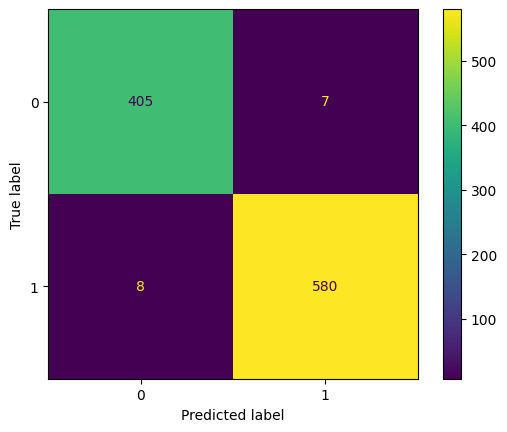

In [10]:
# Training the model with all available features
model.fit(train_x, train_y)

#generate 10000 predictions for 10000 train individuals
train_predictions = model.predict(train_x)

#generate 1000 predictions for 1000 test individuals
test_predictions = model.predict(test_x)


print("Accuracy: \n train: {} | test: {} ".format(skm.accuracy_score(train_y, train_predictions), 
                                                  skm.accuracy_score(test_y, test_predictions))
                                                  ) #Training accuracy / test accuracy


utils.confusion_matrix(test_y, test_predictions)

The model has a high accuracy and a very low misclassification rate. It looks good. But how "fair" is it?

## Fairness assessment

You are now ready to assess the fairness with respect to the various regions where the model will be deployed. Various fairness metrics may be relevant. To make our selection, we consider the harm caused by a misclassification. What do you consider more ominous:


* misdiagnosing individuals with SZ as having AD (*false negative*)

or 

* misdiagnosing individuals with AD as having SZ (*false positive*)?


Why?

#### Examination of regional bias

In [30]:

utils.eval_fairness(test_y, test_predictions, sensitive_var=test['Region'], sensitive_ref='Sør-Øst', metric="FPR")

Region,Midt-Norge,Nord,Sør-Øst,Vest
FPR,0.077670,0.028986,0.005525,0.0
FPR Parity,14.058252,5.246377,1.000000,0.0


- First row shows the metric (false positive rates)
- Second row shows parity (the ratio of the metric between specified group and reference)

False positive rates are low, but disparities in performance are emerging (e.g., patients in Midt-Norge and Nord groups are more likely to be misdiagnosed with SZ)

## Intersectional bias

However, we suspect this bias might only extend to identities defined by the intersecting features of SEX and REGION, so we repeat this analysis for these subgroups

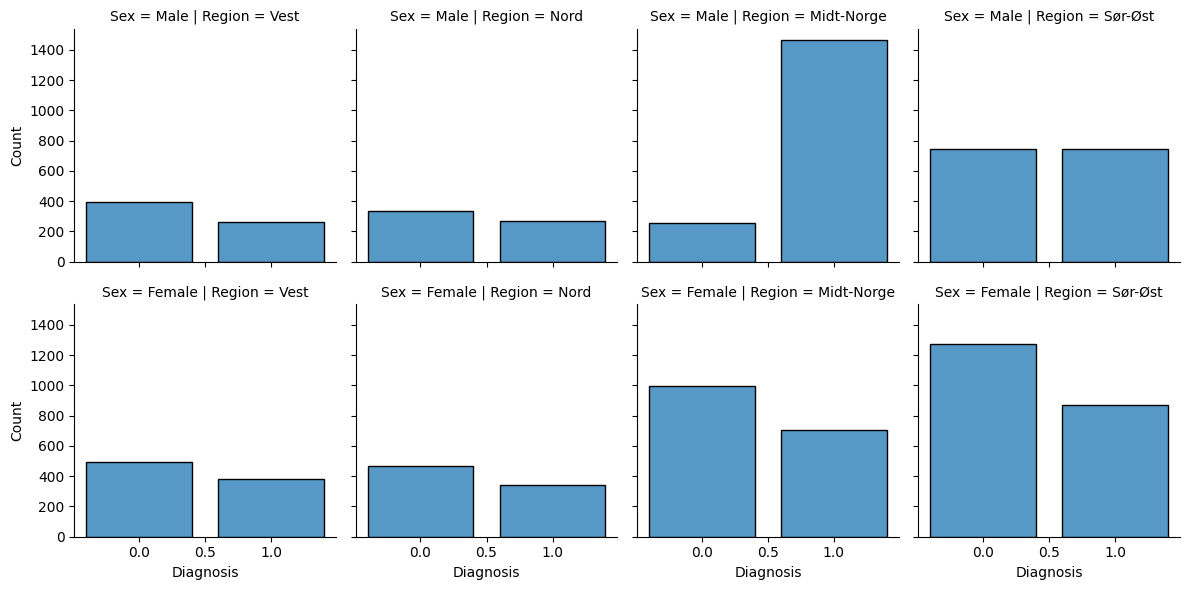

In [31]:
sensitive_var ='Region'
intersect_var = 'Sex'


m = sns.FacetGrid(train, row = intersect_var, col = sensitive_var)
m.map(sns.histplot, "Diagnosis", discrete = True, shrink = .8)

In [42]:
utils.intersectionalf(test_y, test_predictions, test=test,
                 sensitive_var='Region', sensitive_ref='Sør-Øst', 
                 intersect_var='Sex', intersect_ref='Male', 
                 metric="FPR")

Region     Midt-Norge             Nord      Sør-Øst             Vest     
Sex            Female   Male    Female Male  Female      Male Female Male
FPR          0.025641   0.24  0.054054  0.0     0.0  0.013514    0.0  0.0
FPR Parity   1.897436  17.76  4.000000  0.0     0.0  1.000000    0.0  0.0

We see that *men* in *Midt-Norge* are generally more likely to be diagnosed with SZ and almost twice as likely as men in *Sør-Øst*. 

The developing team is perturbed and suggests that the model might be picking up on this trend. They suggest removing "Region" as feature in the model in order to make it "unaware" of "Region". 

Do you think removing "Region" as feature will 

a) improve the FPR for southern men?

b) worsen the FPR for southern men?

c) have no impact on the FPR?

### Retrain without "Region"

Let's remove "Region" and see what happens...

In [43]:
# drop Region-features from train and test
sensitive_var = "Region"
region_cat = [sensitive_var+"_"+v for v in utils.remap_race.values()]
train_x_unaware = train_x.drop(region_cat, axis = 1)
test_x_unaware = test_x.drop(region_cat, axis = 1)

In [44]:
# Train and evaluate a model that is "unaware" of / blind to the feature "Region"

model_unaware = LogisticRegression(penalty = "elasticnet", max_iter=1000, 
                           solver = "saga", l1_ratio=1)
model_unaware = model_unaware.fit(train_x_unaware, train_y)

train_predictions = model_unaware.predict(train_x_unaware)
test_predictions = model_unaware.predict(test_x_unaware)
print("Accuracy: \n train: {} | test: {} ".format(skm.accuracy_score(train_y, train_predictions), 
                                                  skm.accuracy_score(test_y, test_predictions)) 
                                                  )

Accuracy: 
 train: 0.981 | test: 0.982 


In [45]:
utils.eval_fairness(test_y, test_predictions, sensitive_var=test['Region'], sensitive_ref='Sør-Øst', metric='FPR')

Region,Midt-Norge,Nord,Sør-Øst,Vest
FPR,0.077670,0.028986,0.005525,0.0
FPR Parity,14.058252,5.246377,1.000000,0.0


Did removing "Region" from the model fix our problem? How is our new model doing overall?
How many individuals with AD has it misclassified as having SZ?

### Differences in base distributions

Making the model unaware of "Region" did not improve the situation. Instead it seems to have made it worse. Why is that?

Let's have a look at some base distributions. 

In [48]:
# list the variables
print(train.columns)

Index(['Diagnosis', 'Sex', 'Housing', 'Delay', 'Anhedonia', 'Dep_Mood',
       'Sleep', 'Tired', 'Appetite', 'Rumination', 'Concentration',
       'Psychomotor', 'Delusion', 'Suspicious', 'Withdrawal', 'Passive',
       'Tension', 'Unusual_Thought', 'Region'],
      dtype='object')


Let's first look at the features "Anhedonia", "Appetite" and "Delusion":

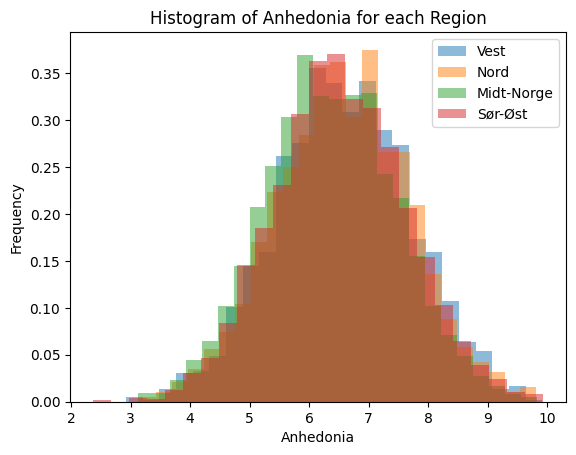

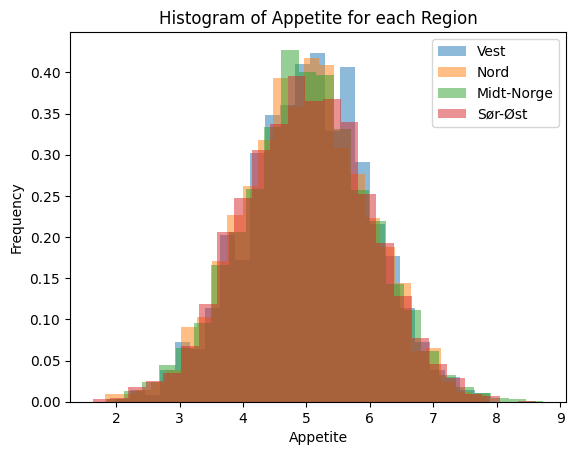

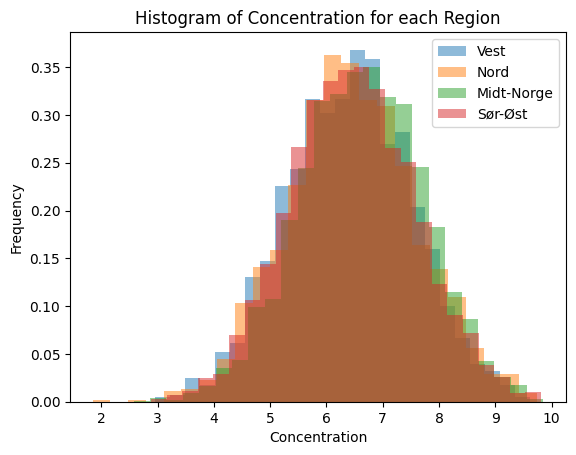

In [49]:
for v in ["Anhedonia", "Appetite", "Concentration"]:
    utils.plot_base_histogram(data=train, inspect_var=v, break_down_on="Region", bins=25)

Let's have a look at a few more:

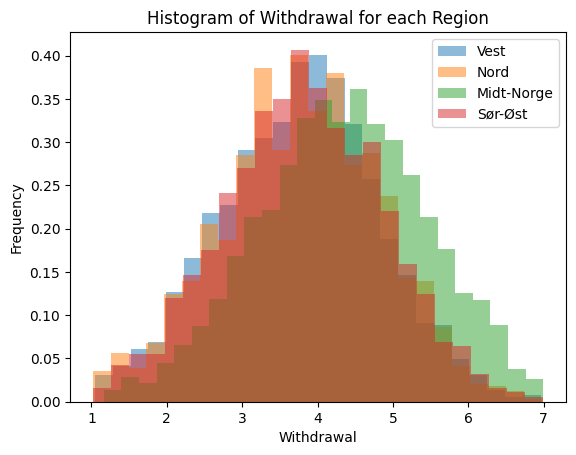

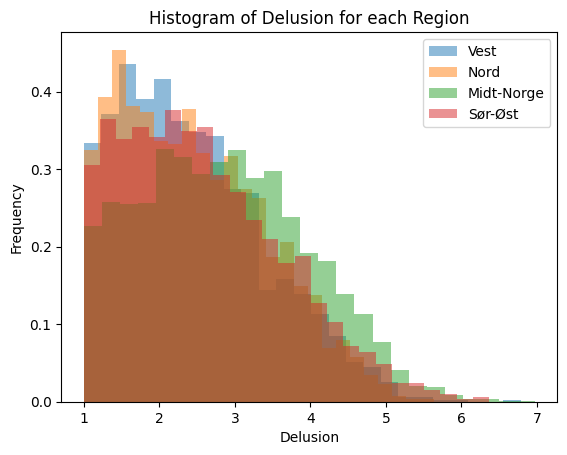

In [50]:
for v in ["Withdrawal", "Delusion"]:
    utils.plot_base_histogram(data=train, inspect_var=v, break_down_on="Region", bins=25)

Here we see that the distributions are more out of phase. The effect is more pronounced between the southern and northern distributions. Differences in base distributions between "populations" will manifest as differences in error rates and outcomes. 

What are likely reasons for these shifts?